In [2]:
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import nclcmaps as ncm
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

In [3]:
importlib.reload(putil)
importlib.reload(ces)

def sph_grad2(x, phi, p, log=False):
    dxdphi, dxdp = xr.zeros_like(x), xr.zeros_like(x)
    dxdp.values, dxdphi.values = np.gradient(x)
    #dxdphi.values, dxdp.values = np.gradient(x, 1/(len(phi)-1), 1/(len(p)-1))
    return dxdphi, dxdp

def sph_grad(x, phi, p, log=False):
    args   = {'dims':x.dims, 'coords':x.coords}
    dxdphi, dxdp = xr.zeros_like(x), xr.zeros_like(x)
    if(log): p = np.log10(p)
    dxdphi.values, dxdp.values = np.gradient(x, phi, p)
    dxdphi *= (lat.max()-lat.min())
    if(not log):
        dxdp *= (p.min()-p.max())
    else:
        p0, p1 = np.max(p.values), np.min(p.values)
        y = np.arange(0, len(p))/len(p)
        dxdp *= p0*(p1/p0)**y * np.log(p1/p0)
    return dxdphi, dxdp

tlim   = [date(1992, 12, 1), date(1993, 3, 1)]
plim = [300, 800]
#latlim = [-30, 30]
#plim = [1, 1000]
latlim = [10, 80]

lev = [1e8, 3e8, 1e9, 3e9, 1e10, 3e10, 1e11]
psilev = [-l for l in lev[::-1]] + [0] + lev
lev = list(2**np.arange(1, 8) * 1e9)
psilev = [-l for l in lev[::-1]] + lev

dslat, dsp = 2, 1
vcolor='k'
pcmap = 'RdYlBu_r'

datasets = ['cfmean', 'impact']

log=False

# ----- read, slice
epdiv = putil.get_variable('epdiv', freq='monthly', tmin=tlim[0], tmax=tlim[1])
epfy = putil.get_variable('epfy', freq='monthly', tmin=tlim[0], tmax=tlim[1])
epfz = putil.get_variable('epfz', freq='monthly', tmin=tlim[0], tmax=tlim[1])
psitem = putil.get_variable('psitem', freq='monthly', tmin=tlim[0], tmax=tlim[1])
psitem_gnlat = putil.get_variable('psitem_gnlat', freq='monthly', tmin=tlim[0], tmax=tlim[1])
psitem_gnp = putil.get_variable('psitem_gnp', freq='monthly', tmin=tlim[0], tmax=tlim[1])
vtem = putil.get_variable('vtem', freq='monthly', tmin=tlim[0], tmax=tlim[1])
wtem = putil.get_variable('wtem', freq='monthly', tmin=tlim[0], tmax=tlim[1])
omtem = putil.get_variable('omegatem', freq='monthly', tmin=tlim[0], tmax=tlim[1])
epdiv = putil.do_slicing(epdiv, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
epfy = putil.do_slicing(epfy, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
epfz = putil.do_slicing(epfz, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
psitem = putil.do_slicing(psitem, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
psitem_gnlat = putil.do_slicing(psitem_gnlat, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
psitem_gnp = putil.do_slicing(psitem_gnp, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
vtem = putil.do_slicing(vtem, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
wtem = putil.do_slicing(wtem, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
omtem = putil.do_slicing(omtem, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])

# ----- get log of streamfunction
psitemlog = {}
for ds in ['impact', 'coherence', 'pval']:
    psitemlog[ds] = psitem[ds]
for ds in datasets:
    psitemlog[ds] = putil.symlog(psitem[ds])

# ----- get coordinates
lat, plev = psitem['cfmean'].lat, psitem['cfmean'].plev

# ----- get streamfunction gradient-normal vectors
glat, gp = {}, {}
gnlat, gnp = {}, {}
glatlog, gplog = {}, {}
gnlatlog, gnplog = {}, {}
for ds in datasets:
    glat[ds], gp[ds]   = sph_grad(psitem[ds], lat, plev, log) # gradient vector components
    gnlat[ds], gnp[ds] = -gp[ds], glat[ds]                    # gradient-normal vector; sign is clockwise around local maxima
    glatlog[ds], gplog[ds]   = sph_grad(psitemlog[ds], lat, plev, log)
    gnlatlog[ds], gnplog[ds] = -gplog[ds], glat[ds]
    
# ----- downsample vetor fields
for ds in datasets:
    vtem[ds] = putil.downsample_latp(vtem[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    wtem[ds] = putil.downsample_latp(wtem[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    omtem[ds] = putil.downsample_latp(omtem[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    gnlat[ds] = putil.downsample_latp(gnlat[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    gnp[ds] = putil.downsample_latp(gnp[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    glat[ds] = putil.downsample_latp(glat[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    gp[ds] = putil.downsample_latp(gp[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    gnlatlog[ds] = putil.downsample_latp(gnlatlog[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    gnplog[ds] = putil.downsample_latp(gnplog[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    glatlog[ds] = putil.downsample_latp(glatlog[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)
    gplog[ds] = putil.downsample_latp(gplog[ds], dslat=dslat, dsp=dsp, interp_lat=True, interp_plev=False)

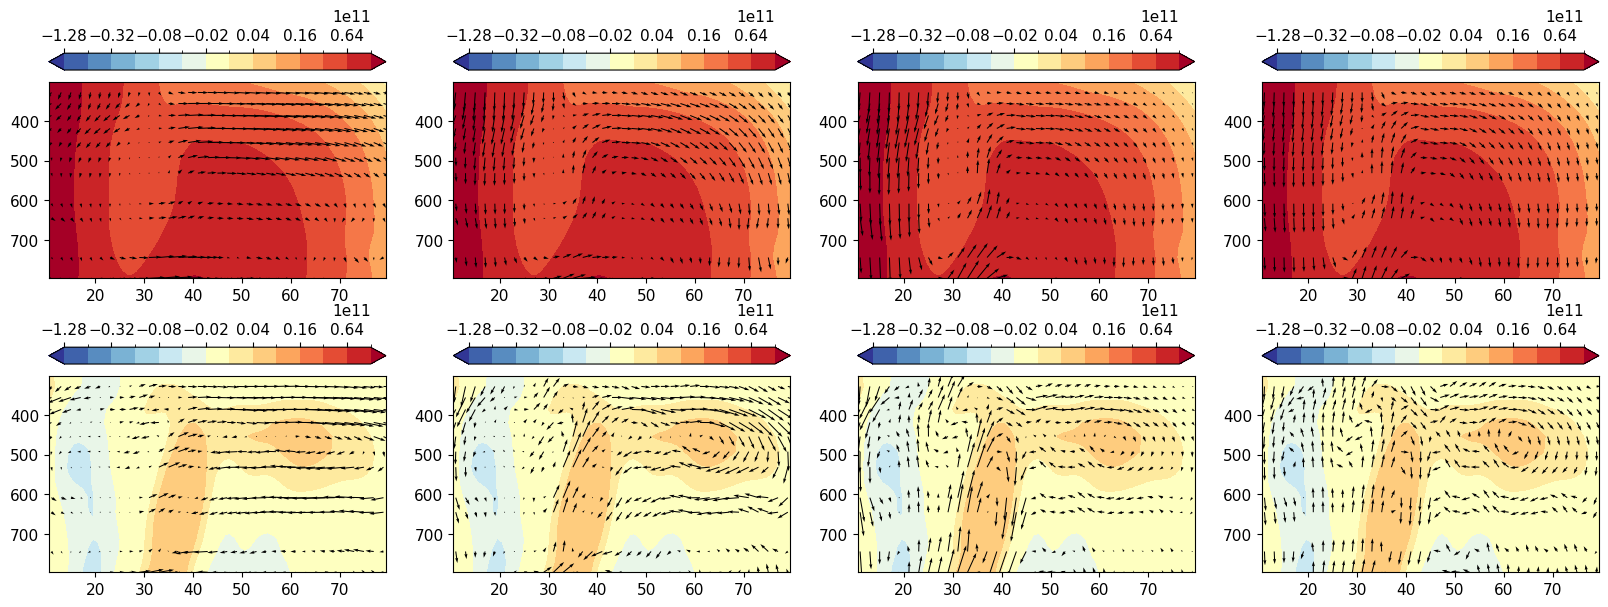

In [4]:
importlib.reload(putil)
importlib.reload(ces)

# ----- create plots
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(241)
ax1i = fig.add_subplot(245)
ax2 = fig.add_subplot(242)
ax2i = fig.add_subplot(246)
ax3 = fig.add_subplot(243)
ax3i = fig.add_subplot(247)
ax4 = fig.add_subplot(244)
ax4i = fig.add_subplot(248)
allax = fig.axes
for ax in allax:
    ax.invert_yaxis()
    if(log):
        ax.set_yscale('log')
    
# ----- get vector field coordinates
LAT, PLEV = np.meshgrid(vtem['cfmean'].lat, vtem['cfmean'].plev)

# ----- plot (vtem, wtem)
axes = [ax1, ax1i]
for i in range(2):
    cc = axes[i].contourf(lat, plev, psitem[datasets[i]].T, levels=psilev, cmap=pcmap, norm=putil.get_cmap_norm(psilev, 'uneven'), extend='both')
    plt.colorbar(cc, location='top', orientation='horizontal')
    axes[i].quiver(LAT, PLEV, vtem[datasets[i]].T, wtem[datasets[i]].T*100, color=vcolor)

# ----- plot (vtem, omegeatem)
axes = [ax2, ax2i]
for i in range(2):
    cc = axes[i].contourf(lat, plev, psitem[datasets[i]].T, levels=psilev, cmap=pcmap, norm=putil.get_cmap_norm(psilev, 'uneven'), extend='both')
    plt.colorbar(cc, location='top', orientation='horizontal')
    axes[i].quiver(LAT, PLEV, vtem[datasets[i]].T, wtem[datasets[i]].T*500, color=vcolor)
    
# ----- plot streamfunction gradient-normal
axes = [ax3, ax3i]
for i in range(2):
    cc = axes[i].contourf(lat, plev, psitem[datasets[i]].T, levels=psilev, cmap=pcmap, norm=putil.get_cmap_norm(psilev, 'uneven'), extend='both')
    plt.colorbar(cc, location='top', orientation='horizontal')
    
    fig_width, fig_height    = fig.get_size_inches()
    _, _, ax_wsize, ax_hsize = axes[i].get_position().bounds
    WW, HH = fig_width * ax_wsize, fig_height * ax_hsize
    
    axes[i].quiver(LAT, PLEV, gnlat[datasets[i]].T * (WW/HH), gnp[datasets[i]].T, color=vcolor)
    #axes[i].quiver(LAT, PLEV, glat[datasets[i]].T * (WW/HH), gp[datasets[i]].T, color='cyan')
    

# ----- plot log streamfunction gradient-normaaxes = [ax3, ax3i]
axes = [ax4, ax4i]
for i in range(2):
    cc = axes[i].contourf(lat, plev, psitem[datasets[i]].T, levels=psilev, cmap=pcmap, norm=putil.get_cmap_norm(psilev, 'uneven'), extend='both')
    plt.colorbar(cc, location='top', orientation='horizontal')
    
    fig_width, fig_height    = fig.get_size_inches()
    _, _, ax_wsize, ax_hsize = axes[i].get_position().bounds
    WW, HH = fig_width * ax_wsize, fig_height * ax_hsize
    
    u, v = putil.log_quiver(gnlat[datasets[i]].T, gnp[datasets[i]].T)
    axes[i].quiver(LAT, PLEV, u, v, color=vcolor)
    #u, v = putil.log_quiver(gnlat[datasets[i]].T, gnp[datasets[i]].T * (WW/HH))
    #axes[i].quiver(LAT, PLEV, u, v, color='hotpink')

plt.show()

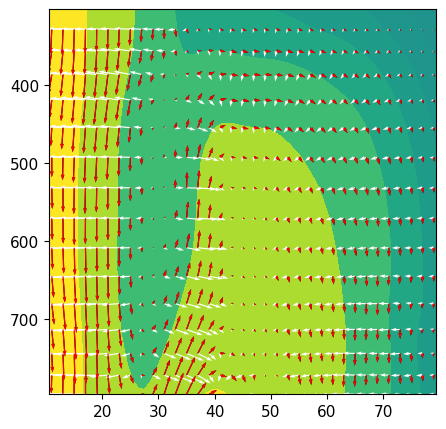

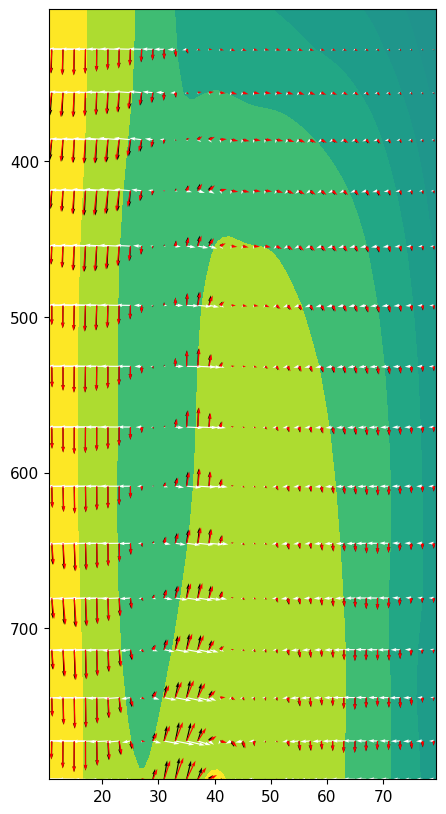

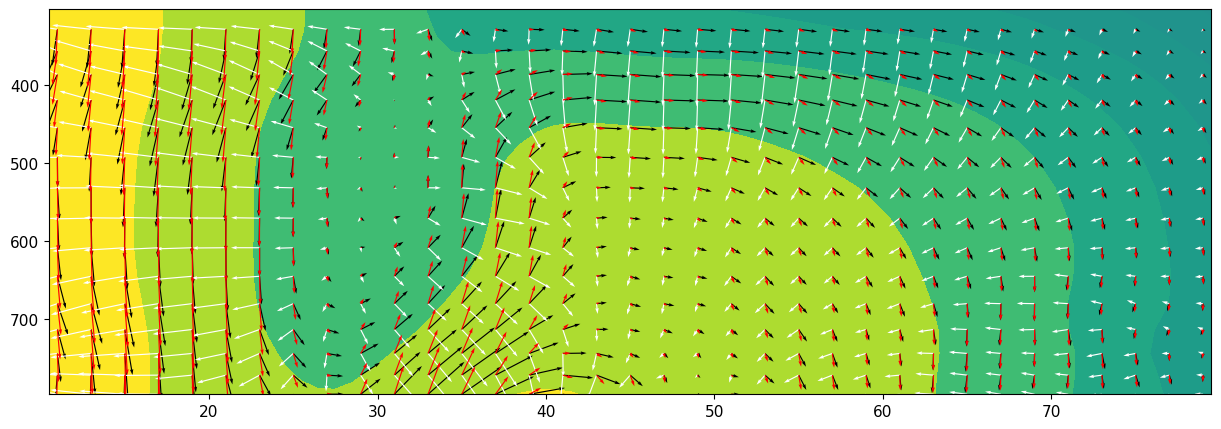

In [8]:
importlib.reload(putil)
importlib.reload(ces)

psi = psitem['cfmean']
logscale=False
log_vectors=False
plot_gradient = True
plot_noaspect_scaling = True


# ------- SQUARE ASPECT
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

LATp, PLEVp = np.meshgrid(psi.lat, psi.plev)
ax.contourf(LATp, PLEVp, psi.T, levels=psilev, extend='both')

ax.invert_yaxis()
if logscale: ax.set_yscale('log')

u, v = putil.streamfunction_gradient_normal(fig, ax, psi, log_vectors=log_vectors, dslat=dslat, dsp=dsp)
LAT, PLEV = np.meshgrid(u.lat, u.plev)
ax.quiver(LAT, PLEV, u.T, v.T, color='k', width=0.003, scale=1e13)
if(plot_gradient):
    ax.quiver(LAT, PLEV, v.T, -u.T, color='w', width=0.003, scale=1e13)
if(plot_noaspect_scaling):
    ax.quiver(LAT, PLEV, u.T * (5/5), v.T, color='r', width=0.003, scale=1e13)


# ------- TALL ASPECT
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)
ax.contourf(LATp, PLEVp, psi.T, levels=psilev, extend='both')

ax.invert_yaxis()
if logscale: ax.set_yscale('log')

u, v = putil.streamfunction_gradient_normal(fig, ax, psi, log_vectors=log_vectors, dslat=dslat, dsp=dsp)
LAT, PLEV = np.meshgrid(u.lat, u.plev)
ax.quiver(LAT, PLEV, u.T, v.T, color='k', width=0.003, scale=1e13)
if(plot_gradient):
    ax.quiver(LAT, PLEV, v.T, -u.T, color='w', width=0.003, scale=1e13)
if(plot_noaspect_scaling):
    ax.quiver(LAT, PLEV, u.T * (10/5), v.T, color='r', width=0.003, scale=1e13)


# ------- WIDE ASPECT
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.contourf(LATp, PLEVp, psi.T, levels=psilev, extend='both')

ax.invert_yaxis()
if logscale: ax.set_yscale('log')

u, v = putil.streamfunction_gradient_normal(fig, ax, psi, log_vectors=log_vectors, dslat=dslat, dsp=dsp)
LAT, PLEV = np.meshgrid(u.lat, u.plev)
ax.quiver(LAT, PLEV, u.T, v.T, color='k', width=0.001, scale=2e13)
if(plot_gradient):
    ax.quiver(LAT, PLEV, v.T, -u.T, color='w', width=0.001, scale=2e13)
if(plot_noaspect_scaling):
    ax.quiver(LAT, PLEV, u.T * (5/15), v.T, color='r', width=0.001, scale=2e13)

# observations:
# - for linear pressure scale, all is fine
# - for log pressure scale:
#    - on a SQUARE plot: using the log-scale arrow scalings (red arrows), either the horizontal component isnt changing fast enough, or the vertical component is changing too fast
#    -                   using the linear-scale arrow scalings (black arrows), the opposite is true. Either the hoizontal component is changing too fast, or the vertical component changes not fast enough...
#                        But wait, horizontal scaling doesnt change either way, so obviously it is the vertical component that is the problem
#                        
# what it looks like is that at high pressures, the vertical component is too large. At low pressures, the opposite might be true, cant really tell 
# so some kind of scaling is required... just haven't found the right form 
#
# observation: All works fine if I log-scale pressure first, and THEN apply the linear vector scaling
# my scalings of the gradient components taken in linear pressure should give the same result...
plt.show()

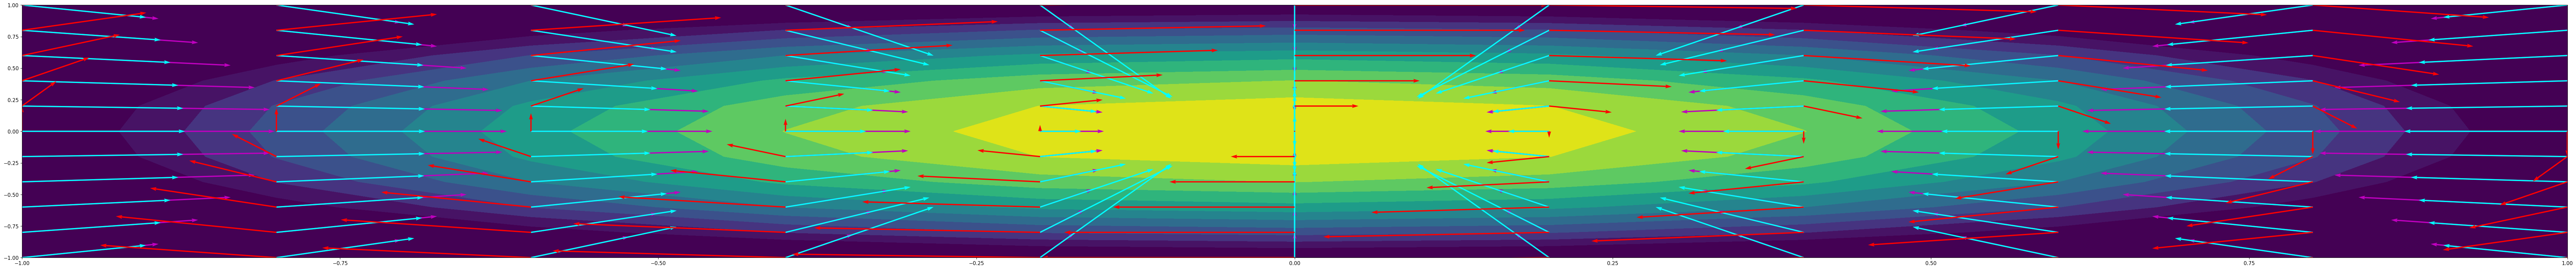

In [6]:
x, y = np.arange(-1,1.1, 0.2), np.arange(-1, 1.1, 0.2)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.cos(Y)

dZy, dZx = np.gradient(Z, x, y)
dZy2, dZx2 = np.gradient(Z, 1/(len(x)-1), 1/(len(y)-1))
dZy, dZx = dZy*2, dZx*2
dnZx, dnZy = -dZy, dZx

fig = plt.figure(figsize=(100,10))
plt.contourf(X, Y, Z, levels=20, vmin=0.6)
plt.quiver(X, Y, dZx*(100/10), dZy, color='m', width=0.0005, angles='uv')
plt.quiver(X, Y, dZx2, dZy2, color='cyan', width=0.0005, angles='xy')
plt.quiver(X, Y, dnZx*(100/10), dnZy, color='red', width=0.0005, angles='uv')
plt.show()

# USING angles='xy' HAS THE SAME EFFECT AS SCALING THE X-COMPONENT BY THE ASPECT RATIO!!!

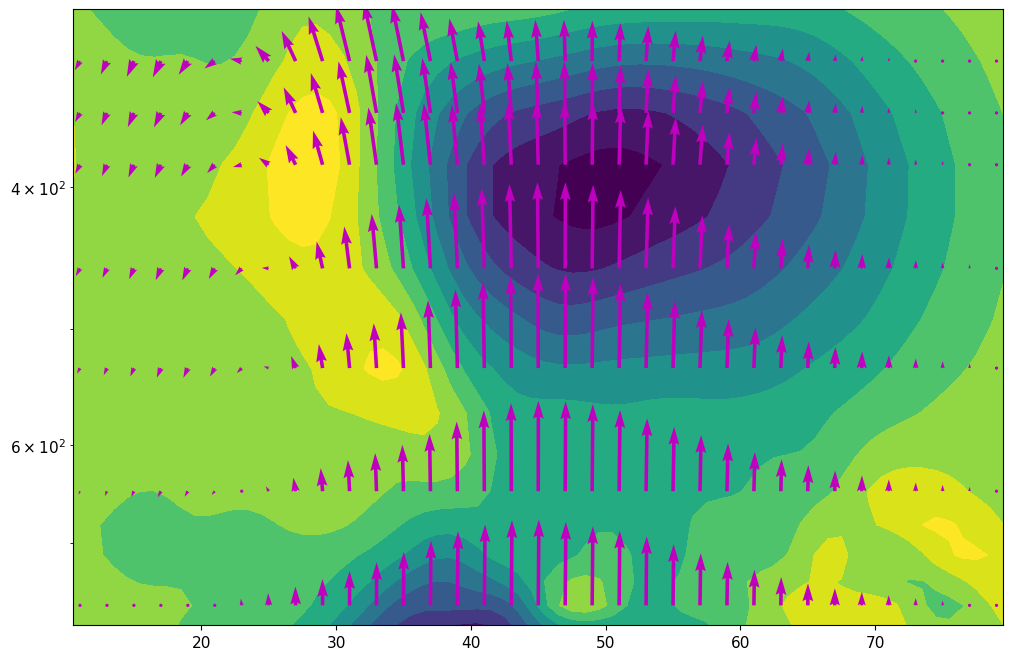

In [7]:
importlib.reload(putil)
importlib.reload(ces)

x, y = lat, plev
X, Y = np.meshgrid(x, y)
Z = epdiv['cfmean']
u, v = epfy['cfmean'], epfz['cfmean']

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.invert_yaxis()
ax.set_yscale('log')
ax.contourf(X, Y, Z.T, levels=12, extend='both')

u, v = putil.scale_EP_flux_vectors(fig, ax, u, v, dslat=2, dsp=2)
X, Y = np.meshgrid(u.lat, u.plev)
ax.quiver(X, Y, u.T, v.T, color='m')

plt.show()